In [1]:
import pandas as pd
import seaborn as sns
import scipy
import numpy as np
from lightfm import LightFM
from lightfm.evaluation import precision_at_k,auc_score

In [2]:
ratings=pd.read_csv('ratings.csv')
books=pd.read_csv('books.csv')

In [3]:
ratings[['book_id','user_id']].duplicated().sum()

2278

<AxesSubplot:xlabel='rating', ylabel='count'>

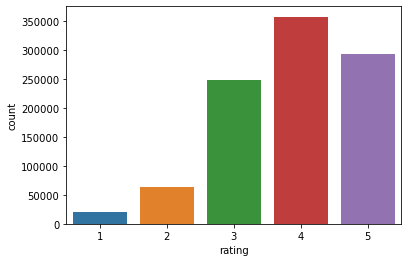

In [4]:
sns.countplot('rating',data=ratings)

In [5]:
books['original_title']

0                                        The Hunger Games
1                Harry Potter and the Philosopher's Stone
2                                                Twilight
3                                   To Kill a Mockingbird
4                                        The Great Gatsby
                              ...                        
9995                                           Bayou Moon
9996                                     Means of Ascent 
9997                                The Mauritius Command
9998    Cinderella Ate My Daughter: Dispatches from th...
9999                                  The First World War
Name: original_title, Length: 10000, dtype: object

# Pivot Table

User rating as rows and book_id as columns

In [6]:
%%time
train_data=ratings.pivot_table(values='rating',index='user_id',columns='book_id')
train_data=train_data.fillna(0)
print(train_data.shape)

(53424, 10000)
Wall time: 1min 2s


In [7]:
# Conver to compressed sparse matrix
train_data=scipy.sparse.csr_matrix(train_data.values)

# Train on Model
Train the model on LightFM which uses a hybrid approach of collborative and content filtering to give give recommentaion score   

In [8]:
model = LightFM(learning_rate=0.05,loss='warp')
model.fit(train_data, epochs=30, num_threads=8)

train_precision = precision_at_k(model, train_data, k=5).mean()
train_auc = auc_score(model, train_data).mean()

print('Precision: train %.2f' % (train_precision))
print('AUC: train %.2f' % (train_auc))

Precision: train 0.20
AUC: train 0.97


In [9]:
def recommendation_sys(model,data,user_ids):
    """
    Function to ouput recommendation for random users  
    """
    n_users, n_items = data.shape
    for user_id in user_ids:
        #know positive
        kp=books['original_title'][data[user_id].indices]
        score=model.predict(user_id,np.arange(n_items))
        top_items=books['original_title'][np.argsort(-score)]
        #print out the results
        print("User %s" % user_id)
        print("     Known positives:")
        for x in kp[:3]:
            print("        %s" % x)
        print("     Recommended:")
        for x in top_items[:3]:
            print("        %s" % x)
            
recommendation_sys(model, train_data, np.random.randint(1000,size=3))

User 31
     Known positives:
        The School of Essential Ingredients
        A Homemade Life: Stories and Recipes from My Kitchen Table
        Take the Cannoli: Stories from the New World
     Recommended:
        nan
        A Homemade Life: Stories and Recipes from My Kitchen Table
        The Dirty Life: On Farming, Food, and Love
User 220
     Known positives:
        Knowing God
        The Obsession
        When I'm Gone
     Recommended:
        The Seven Principles for Making Marriage Work: A Practical Guide from the Country's Foremost Relationship Expert
        The Return of the Prodigal Son: A Story of Homecoming
        The Knowledge of the Holy: The Attributes of God: Their Meaning in the Christian Life
User 920
     Known positives:
        Vegan Cupcakes Take Over the World: 75 Dairy-Free Recipes for Cupcakes that Rule
        On Becoming Baby Wise: Giving Your Infant the Gift of Nighttime Sleep
        Healthy Sleep Habits, Happy Child
     Recommended:
        Th